# Training the Model

In [21]:
import sys
sys.path.append("../src")
from model import FoodRegressor
from data_loader import FoodDataset
from utils import get_transforms
from optimizer import Optimizer
import torch
from torch.utils.data import random_split
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd

Set the device

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Build an unnormalized dataset. This step accounts for images that didn't download originally.

In [20]:
transform = get_transforms()

base_dataset = FoodDataset(
    csv_path="../data/cleaned-food-data.csv",
    img_dir="../data/data/images",
    transform=transform,
    target_mean=None,
    target_std=None
)

print("Filtered dataset size:", len(base_dataset))

Filtered dataset size: 14994


Gete training and validation indices so we can normalize the output on the training set.

In [23]:
n = len(base_dataset) # total samples
n_val = int(n * 0.2) # 80-20 train val split
n_train = n - n_val

all_indices = torch.randperm(n) # shuffle the data
train_indices = all_indices[:n_train].tolist() # indices for training samples
val_indices = all_indices[n_train:].tolist() # indices for val samples

targets_all = base_dataset.targets # all of the targets in the base dataset
train_targets = targets_all[train_indices]

# Calculate mean and std dev of training set to normalize targets
target_mean = train_targets.mean(axis = 0).astype("float32")
target_std = train_targets.std(axis = 0).astype("float32")

# Check output
print("Training set mean: ", target_mean)
print("Training set standard deviation: ", target_std)

Training set mean:  [352.025    399.90405   22.08835   17.62404   36.394875]
Training set standard deviation:  [171.30759  252.42459   17.722845  15.020849  29.155783]


Define the train and val dataset objects with our calculated mean and std dev

In [25]:
transform = get_transforms()

dataset = FoodDataset(
    csv_path="../data/cleaned-food-data.csv",
    img_dir="../data/data/images",
    transform=transform,
    target_mean=target_mean,
    target_std=target_std
)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

Define the train and val dataloader objects

In [27]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)

Define the model 

In [28]:
num_dishes = len(dataset.dish_to_id) # Get the number of total dishes in the dataset

model = FoodRegressor(
    pretrained_model_name = "resnet18",
    num_dishes = num_dishes,
    hidden_dim = 512,
    dish_emb_dim = 32,
    dropout = 0.0,
    out_dim = 5, 
    freeze_pretrained = True
    ).to(device)

Define the optimizer

In [29]:
opt = Optimizer(
    model = model,
    train_data = train_loader,
    val_data = val_loader,
    epochs = 15,
    lr = 1e-4,
    device = device,
    use_scheduler = True,
    patience = 3 
)

Train the model

[Training] Epoch 1/15:  59%|█████▉    | 222/375 [06:53<04:24,  1.73s/it]/home/c18ty/DSAN_6600/.venv/lib/python3.13/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
[Validation] Epoch 15/15: 100%|██████████| 94/94 [03:31<00:00,  2.25s/it]


Early stopping activated due to overfitting.
Restoring best model (val_loss=0.2900)



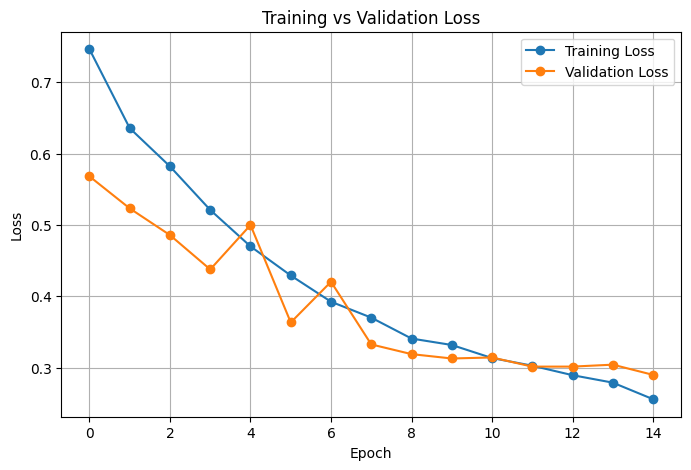

In [30]:
trained_model = opt.train()
opt.plot()

Save Model

In [31]:
save_path = "../models/model_1.pt"
torch.save(trained_model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to ../models/model_1.pt


Save Model Results

In [32]:
import json

results = {
    "train_losses": opt.training_losses,
    "val_losses": opt.validation_losses,
    "target_mean": target_mean.tolist(),
    "target_std": target_std.tolist()
}

with open("../models/model1_metadata.json", "w") as f:
    json.dump(results, f, indent=4)